### Tutorial

Install & import **Qdrant** and **FastEmbed**

We will **FastEmbed** for generating multimodal embeddings and **Qdrant** for storing and retrieving them.

In [1]:
!python3 -m pip install --upgrade qdrant-client fastembed Pillow

In [2]:
from qdrant_client import QdrantClient, models

client = QdrantClient(
    ":memory:"
)  #:memory: option is suitable only for simple prototypes/demos with Python client (!)

Let's embed a very short selection of images and their captions in the **shared embedding space** with CLIP.

In [3]:
from fastembed import TextEmbedding, ImageEmbedding


documents = [
    {"caption": "A photo of a cute pig", "image": "images/piggy.jpg"},
    {"caption": "A picture with a coffee cup", "image": "images/coffee.jpg"},
    {"caption": "A photo of a colourful lizard", "image": "images/lizard.jpg"},
]

text_model_name = "Qdrant/clip-ViT-B-32-text"  # CLIP text encoder
text_model = TextEmbedding(model_name=text_model_name)
text_embeddings_size = text_model._get_model_description(text_model_name)[
    "dim"
]  # dimension of text embeddings, produced by CLIP text encoder (512)
texts_embeded = list(
    text_model.embed([document["caption"] for document in documents])
)  # embedding captions with CLIP text encoder

image_model_name = "Qdrant/clip-ViT-B-32-vision"  # CLIP image encoder
image_model = ImageEmbedding(model_name=image_model_name)
image_embeddings_size = image_model._get_model_description(image_model_name)[
    "dim"
]  # dimension of image embeddings, produced by CLIP image encoder (512)
images_embeded = list(
    image_model.embed([document["image"] for document in documents])
)  # embedding images with CLIP image encoder

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Create a **Collection**

In [4]:
if not client.collection_exists("text_image"):  # creating a Collection
    client.create_collection(
        collection_name="text_image",
        vectors_config={  # Named Vectors
            "image": models.VectorParams(
                size=image_embeddings_size, distance=models.Distance.COSINE
            ),
            "text": models.VectorParams(
                size=text_embeddings_size, distance=models.Distance.COSINE
            ),
        },
    )

Now let's upload our images with captions to the **Collection**. Each image with its caption will create a [Point](https://qdrant.tech/documentation/concepts/points/) in Qdrant.

In [5]:
client.upload_points(
    collection_name="text_image",
    points=[
        models.PointStruct(
            id=idx,  # unique id of a point, pre-defined by user
            vector={
                "text": texts_embeded[idx],  # embeded caption
                "image": images_embeded[idx],  # embeded image
            },
            payload=doc,  # original image and its caption
        )
        for idx, doc in enumerate(documents)
    ],
)

Let'see what image we will get to the query "*What would make me energetic in the morning?*"

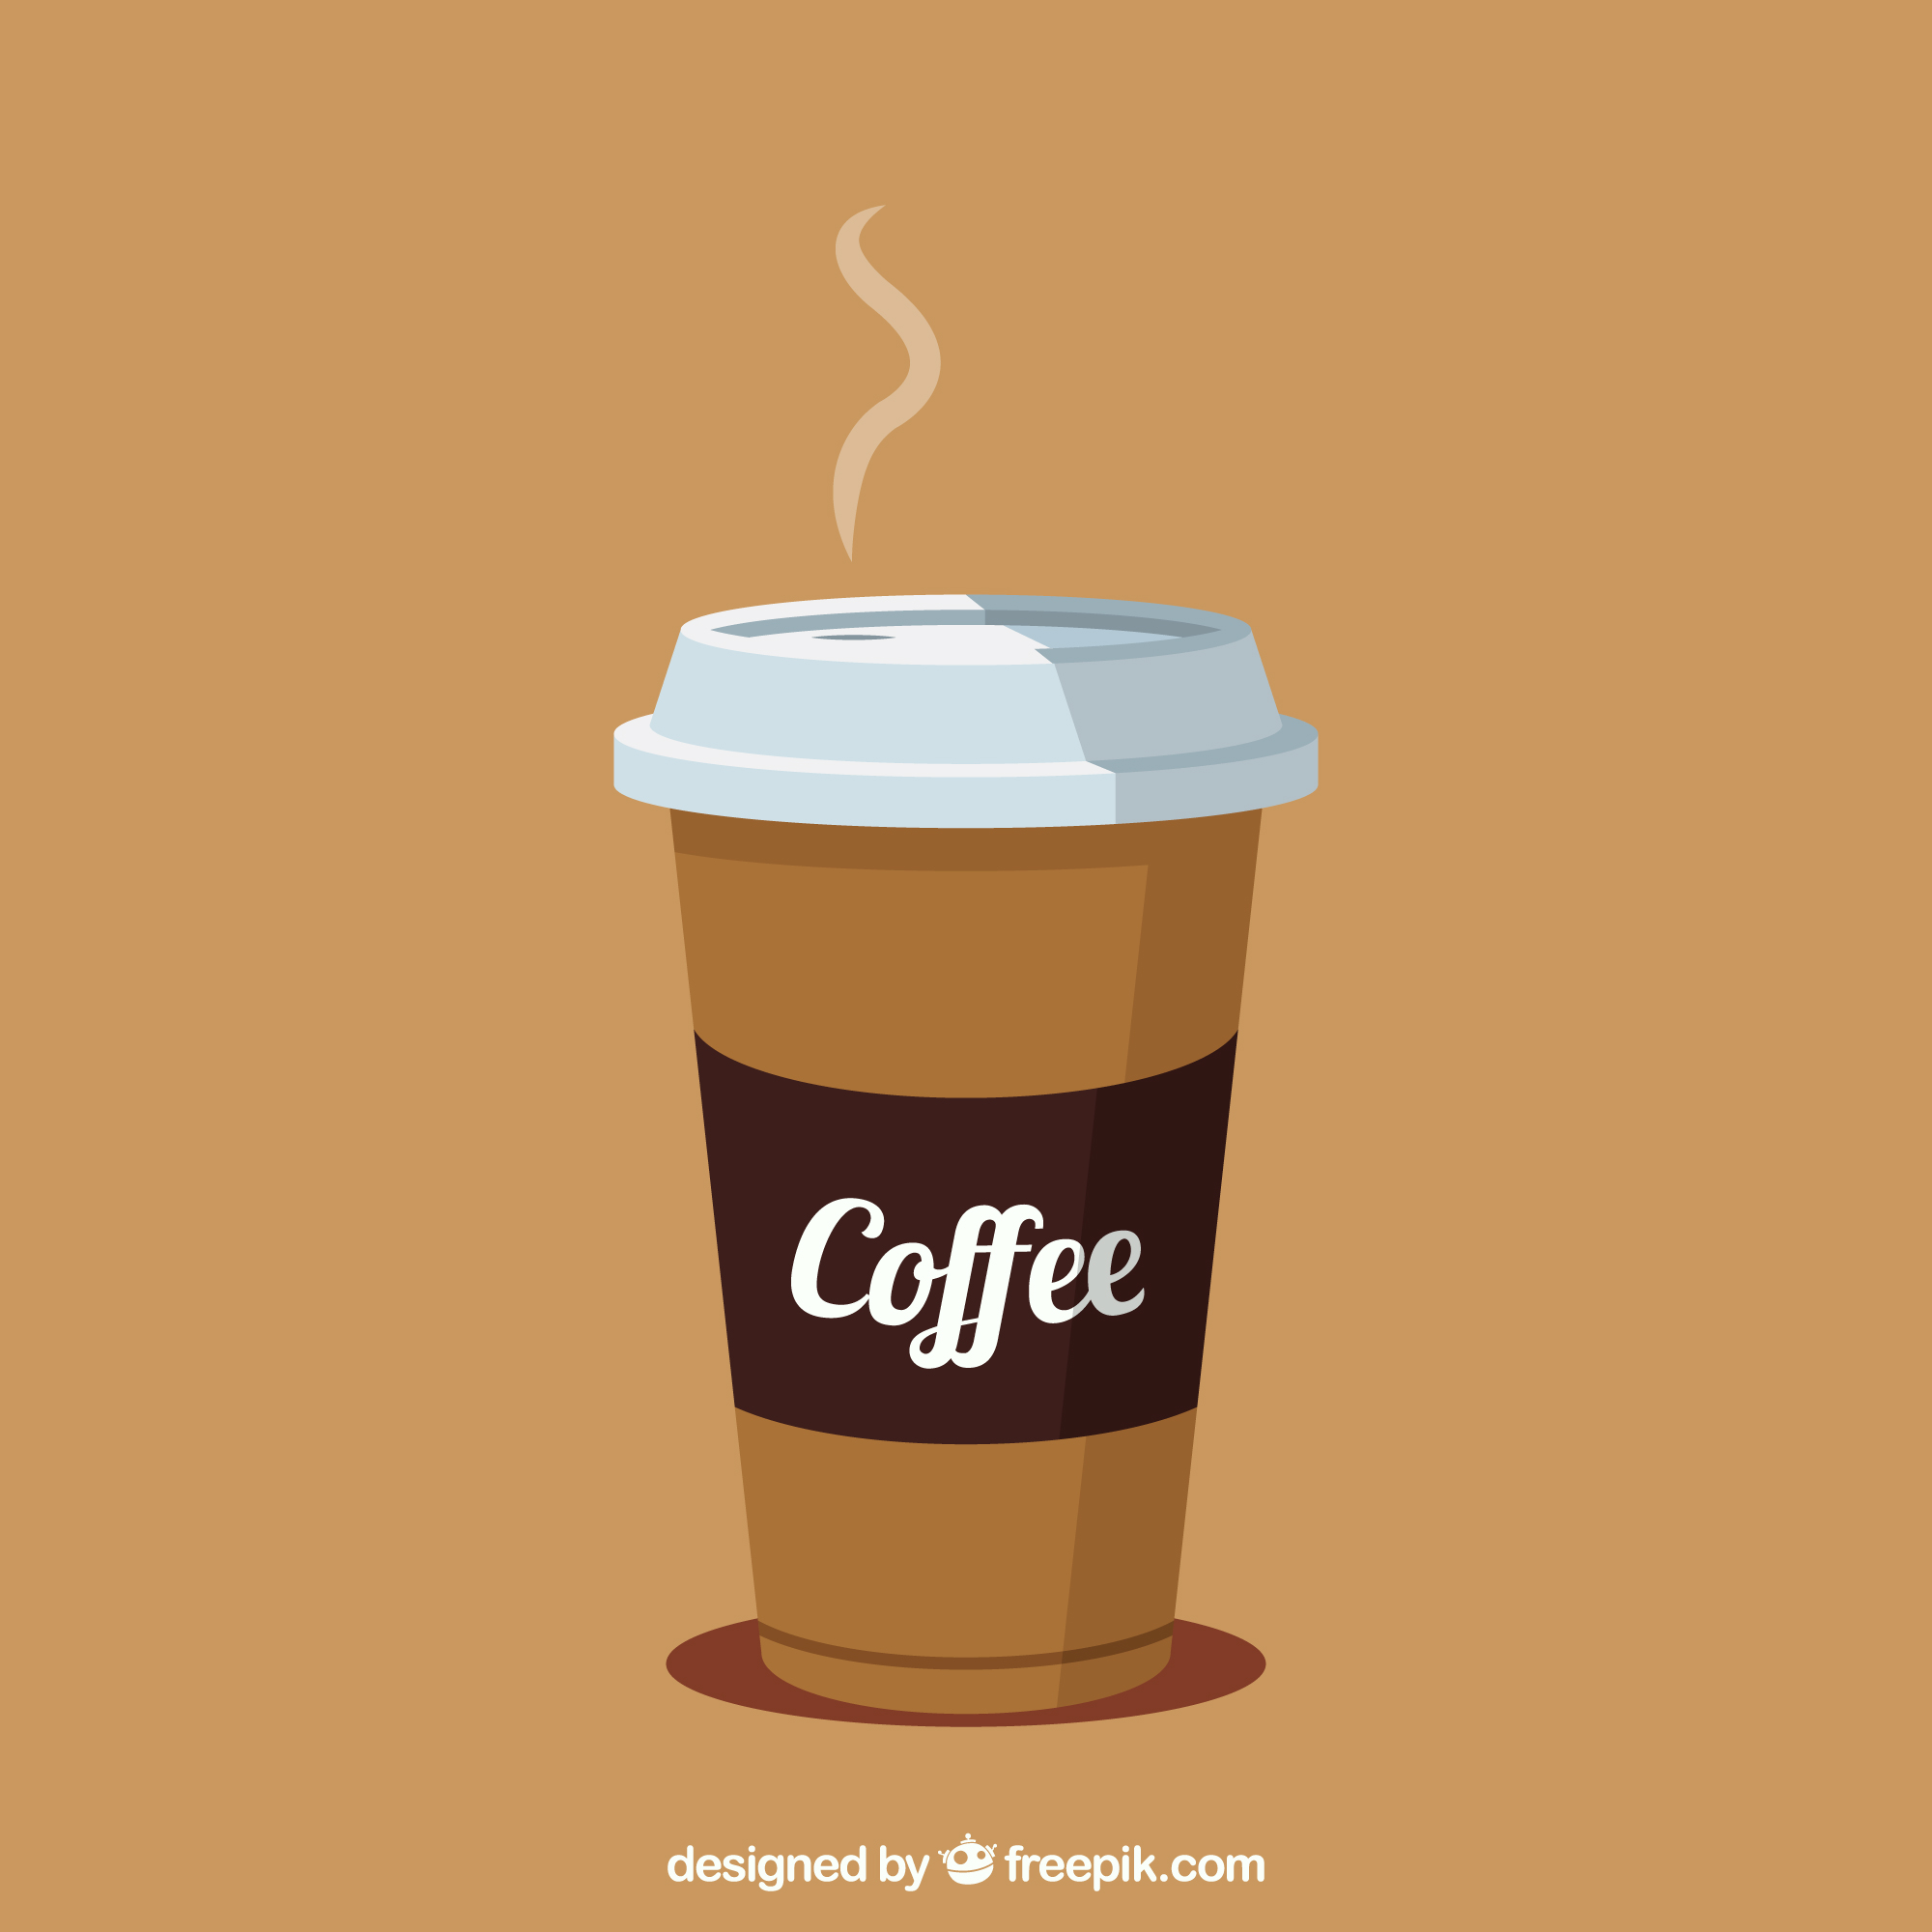

In [6]:
from PIL import Image

find_image = text_model.embed(
    ["What would make me energetic in the morning?"]
)  # query, we embed it, so it also becomes a vector

Image.open(
    client.search(
        collection_name="text_image",  # searching in our collection
        query_vector=(
            "image",
            list(find_image)[0],
        ),  # searching only among image vectors with our textual query
        with_payload=[
            "image"
        ],  # user-readable information about search results, we are interested to see which image we will find
        limit=1,  # top-1 similar to the query result
    )[0].payload["image"]
)

Now let's do a reverse search:

Let'see what caption we will get, searching by the piglet image, which, as you can check, is not in our **Collection**:

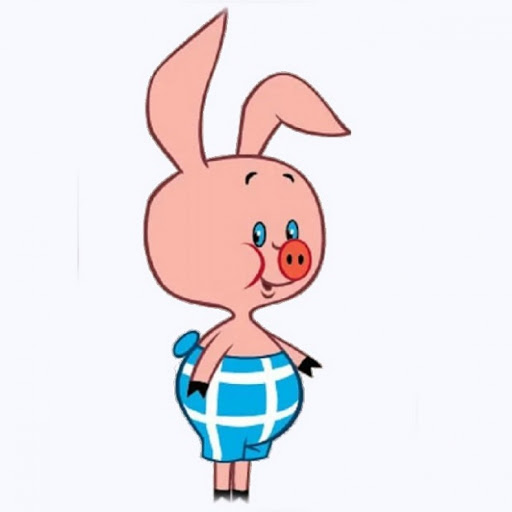

In [7]:
Image.open("images/piglet.jpg")  # to display what are we working with

In [8]:
find_image = image_model.embed(["images/piglet.jpg"])  # embedding our image query

client.search(
    collection_name="text_image",
    query_vector=(
        "text",
        list(find_image)[0],
    ),  # now we are searching only among text vectors with our image query
    with_payload=[
        "caption"
    ],  # user-readable information about search results, we are interested to see which caption we will get
    limit=1,
)[0].payload["caption"]

'A photo of a cute pig'